In [1]:
#https://pysal.org/libpysal/notebooks/weights.html
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000) ## 800GB?

from libpysal.weights import Queen, Rook, KNN

from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg

from shapely import wkb
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# import contextily
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns

import branca
import folium
import shared_utils

from siuba import *

pd.set_option('display.max_columns', None) 

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
gdf = gpd.read_parquet('gs://calitp-analytics-data/data-analyses/ahsc_grant/analytical_tbl.parquet')
gdf = gdf.dropna()
gdf

,calitp_itp_id,stop_id,geometry,stop_name,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_earlyam,n_trips_latepm,n_trips_sat,n_trips_sun,n_trips_weekday,sat_ons,sun_ons,weekday_ons,sum_tracts,sum_total_pop,sum_households,sum_not_us_citizen_pop,sum_black_pop,sum_hispanic_pop,sum_youth_pop,sum_seniors_pop,sum_inc_extremelylow,sum_inc_verylow,sum_inc_low,sum_pop_determined_poverty_status,sum_poverty,sum_no_car,sum_no_cars,sum_land_area,sum_jobs,land_area_sqkm,pop_density,job_density,pct_not_us_citizen_pop,pct_black_pop,pct_hispanic_pop,pct_youth_pop,pct_seniors_pop,pct_inc_extremelylow,pct_inc_verylow,pct_inc_low,pct_poverty,pct_pop_workers_no_car,pct_hh_no_cars
0,293,670,POINT (19317.277 -398155.080),Turnpike & Ukiah,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,330.0,2,8120.0,2912.0,390.0,24.0,2348.0,2475.0,1796.0,395.0,214.0,346.0,8072.0,945.0,57.0,151.0,14540194,1774.0,14.540194,558.451971,122.006625,0.048030,0.002956,0.289163,0.304803,0.221182,0.135646,0.073489,0.118819,0.117071,0.007020,0.051854
1,293,1078,POINT (21987.751 -396450.181),Primavera & Verano,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,11850.0,4594.0,844.0,309.0,3006.0,3204.0,2602.0,970.0,525.0,929.0,10723.0,1038.0,112.0,235.0,6250912,9658.0,6.250912,1895.723376,1545.054546,0.071224,0.026076,0.253671,0.270380,0.219578,0.211145,0.114279,0.202220,0.096801,0.009451,0.051154
2,293,217,POINT (27311.975 -399717.150),De La Vina & Canon Perdido,3.0,5.0,4.0,0.0,2.0,12.0,11.0,14.0,104.0,78.0,1552.0,2,9570.0,4744.0,1421.0,246.0,3993.0,2674.0,1400.0,1355.0,834.0,905.0,9525.0,1758.0,441.0,872.0,3008305,20871.0,3.008305,3181.193396,6937.793874,0.148485,0.025705,0.417241,0.279415,0.146290,0.285624,0.175801,0.190767,0.184567,0.046082,0.183811
3,293,288,POINT (22859.915 -396883.733),La Cumbre & La Colina,11.0,20.0,14.0,0.0,1.0,11.0,11.0,46.0,13.0,8.0,570.0,2,9948.0,4340.0,773.0,34.0,1952.0,2613.0,2482.0,594.0,505.0,834.0,9751.0,716.0,130.0,379.0,5282353,10611.0,5.282353,1883.251649,2008.763897,0.077704,0.003418,0.196220,0.262666,0.249497,0.136866,0.116359,0.192166,0.073428,0.013068,0.087327
4,293,203,POINT (25145.268 -398574.222),Junipero & Alamar,8.0,10.0,8.0,0.0,1.0,12.0,11.0,27.0,93.0,38.0,911.0,3,16624.0,6945.0,1993.0,95.0,5241.0,4185.0,3693.0,920.0,993.0,1245.0,16393.0,1382.0,154.0,529.0,8935899,9756.0,8.935899,1860.361224,1091.775993,0.119887,0.005715,0.315267,0.251744,0.222149,0.132469,0.142981,0.179266,0.084304,0.009264,0.076170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13741,208,1619,POINT (-169553.548 -154399.663),Cannery Row / Drake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2408.0,2726.0,6526.0,2,7363.0,2299.0,402.0,166.0,1200.0,2859.0,942.0,283.0,353.0,486.0,5076.0,700.0,73.0,122.0,3296510,4017.0,3.296510,2233.574295,1218.561448,0.054597,0.022545,0.162977,0.388293,0.127937,0.123097,0.153545,0.211396,0.137904,0.009914,0.053067
13742,208,1623,POINT (-169757.062 -154073.881),Wave / Cr1 Parking Garage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2744.0,4408.0,7028.0,2,6679.0,3176.0,494.0,77.0,899.0,1295.0,1558.0,457.0,459.0,726.0,6586.0,843.0,93.0,220.0,2451844,4912.0,2.451844,2724.072168,2003.390101,0.073963,0.011529,0.134601,0.193891,0.233268,0.143892,0.144521,0.228589,0.127999,0.013924,0.069270
13743,208,5102,POINT (-148711.025 -147857.530),Hartnell College Parking Garage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4267.0,2,6744.0,2179.0,1049.0,135.0,4123.0,2494.0,867.0,343.0,403.0,609.0,6701.0,1182.0,27.0,46.0,2088691,3512.0,2.088691,3228.816517,1681.435885,0.155546,0.020018,0.611358,0.369810,0.128559,0.157412,0.184947,0.279486,0.176392,0.004004,0.021111
13744,208,1616,POINT (-169831.216 -153784.483),Cannery Row / Aquarium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28952.0,31204.0,74045.0,3,8768.0,4138.0,546.0,115.0,1130.0,1852.0,2040.0,552.0,637.0,931.0,8675.0,946.0,118.0,248.0,3015234,5586.0,3.015234,2907.900349,1852.592535,0.062272,0.013116,0.128878,0.21122

In [3]:
gdf['weekday_ons'].describe()

count     13723.000000
mean       9171.404341
std       20698.751173
min           0.000000
25%         595.610731
50%        2382.442926
75%        8505.321246
max      496433.000000
Name: weekday_ons, dtype: float64

<AxesSubplot:xlabel='weekday_ons', ylabel='Count'>

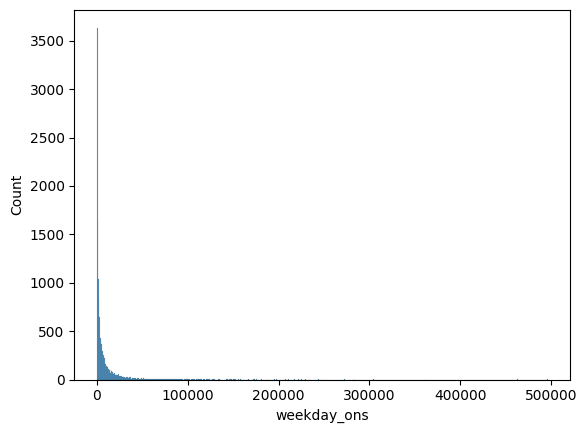

In [4]:
sns.histplot(gdf['weekday_ons'])

<AxesSubplot:xlabel='weekday_ons', ylabel='Count'>

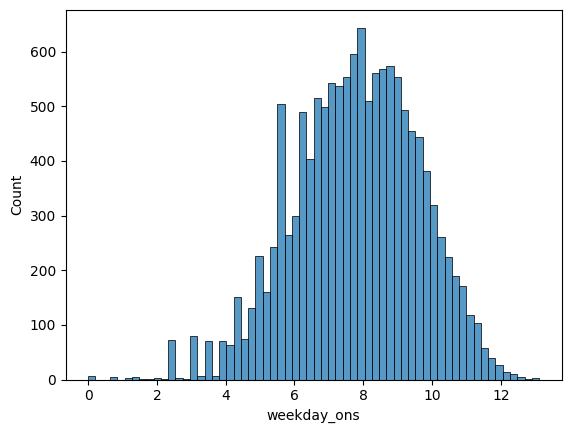

In [5]:
sns.histplot(np.log(gdf['weekday_ons']))

In [6]:
gdf.columns

Index(['calitp_itp_id', 'stop_id', 'geometry', 'stop_name', 'n_trips_ampeak',
       'n_trips_midday', 'n_trips_pmpeak', 'n_trips_earlyam', 'n_trips_latepm',
       'n_trips_sat', 'n_trips_sun', 'n_trips_weekday', 'sat_ons', 'sun_ons',
       'weekday_ons', 'sum_tracts', 'sum_total_pop', 'sum_households',
       'sum_not_us_citizen_pop', 'sum_black_pop', 'sum_hispanic_pop',
       'sum_youth_pop', 'sum_seniors_pop', 'sum_inc_extremelylow',
       'sum_inc_verylow', 'sum_inc_low', 'sum_pop_determined_poverty_status',
       'sum_poverty', 'sum_no_car', 'sum_no_cars', 'sum_land_area', 'sum_jobs',
       'land_area_sqkm', 'pop_density', 'job_density',
       'pct_not_us_citizen_pop', 'pct_black_pop', 'pct_hispanic_pop',
       'pct_youth_pop', 'pct_seniors_pop', 'pct_inc_extremelylow',
       'pct_inc_verylow', 'pct_inc_low', 'pct_poverty',
       'pct_pop_workers_no_car', 'pct_hh_no_cars'],
      dtype='object')

In [7]:
# Multiply all percentage columns by 100 for easier OLS interpretation
for column in gdf.columns:
    if 'pct' in column:
        gdf[column] = gdf[column] * 100
gdf.head()

,calitp_itp_id,stop_id,geometry,stop_name,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_earlyam,n_trips_latepm,n_trips_sat,n_trips_sun,n_trips_weekday,sat_ons,sun_ons,weekday_ons,sum_tracts,sum_total_pop,sum_households,sum_not_us_citizen_pop,sum_black_pop,sum_hispanic_pop,sum_youth_pop,sum_seniors_pop,sum_inc_extremelylow,sum_inc_verylow,sum_inc_low,sum_pop_determined_poverty_status,sum_poverty,sum_no_car,sum_no_cars,sum_land_area,sum_jobs,land_area_sqkm,pop_density,job_density,pct_not_us_citizen_pop,pct_black_pop,pct_hispanic_pop,pct_youth_pop,pct_seniors_pop,pct_inc_extremelylow,pct_inc_verylow,pct_inc_low,pct_poverty,pct_pop_workers_no_car,pct_hh_no_cars
0,293,670,POINT (19317.277 -398155.080),Turnpike & Ukiah,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,330.0,2,8120.0,2912.0,390.0,24.0,2348.0,2475.0,1796.0,395.0,214.0,346.0,8072.0,945.0,57.0,151.0,14540194,1774.0,14.540194,558.451971,122.006625,4.802956,0.295567,28.916256,30.480296,22.118227,13.564560,7.348901,11.881868,11.707136,0.701970,5.185440
1,293,1078,POINT (21987.751 -396450.181),Primavera & Verano,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,11850.0,4594.0,844.0,309.0,3006.0,3204.0,2602.0,970.0,525.0,929.0,10723.0,1038.0,112.0,235.0,6250912,9658.0,6.250912,1895.723376,1545.054546,7.122363,2.607595,25.367089,27.037975,21.957806,21.114497,11.427949,20.222029,9.680127,0.945148,5.115368
2,293,217,POINT (27311.975 -399717.150),De La Vina & Canon Perdido,3.0,5.0,4.0,0.0,2.0,12.0,11.0,14.0,104.0,78.0,1552.0,2,9570.0,4744.0,1421.0,246.0,3993.0,2674.0,1400.0,1355.0,834.0,905.0,9525.0,1758.0,441.0,872.0,3008305,20871.0,3.008305,3181.193396,6937.793874,14.848485,2.570533,41.724138,27.941484,14.629049,28.562395,17.580101,19.076728,18.456693,4.608150,18.381113
3,293,288,POINT (22859.915 -396883.733),La Cumbre & La Colina,11.0,20.0,14.0,0.0,1.0,11.0,11.0,46.0,13.0,8.0,570.0,2,9948.0,4340.0,773.0,34.0,1952.0,2613.0,2482.0,594.0,505.0,834.0,9751.0,716.0,130.0,379.0,5282353,10611.0,5.282353,1883.251649,2008.763897,7.770406,0.341777,19.622035,26.266586,24.949739,13.686636,11.635945,19.216590,7.342837,1.306795,8.732719
4,293,203,POINT (25145.268 -398574.222),Junipero & Alamar,8.0,10.0,8.0,0.0,1.0,12.0,11.0,27.0,93.0,38.0,911.0,3,16624.0,6945.0,1993.0,95.0,5241.0,4185.0,3693.0,920.0,993.0,1245.0,16393.0,1382.0,154.0,529.0,8935899,9756.0,8.935899,1860.361224,1091.775993,11.988691,0.571463,31.526708,25.174447,22.214870,13.246940,14.298056,17.926566,8.430428,0.926372,7.616991


In [15]:
# Weekday_ons ~ n_trips_weekday + pop_density + job_density + pct: 
# Intuition is to only use use pct variables because we don’t want to double count people in areas around multiple stops. Whereas, trips are characteristic of the stop itself

explanatory_vars = ['n_trips_weekday','pop_density', 'pct_not_us_citizen_pop',
                    'pct_youth_pop', 'pct_seniors_pop', 'pct_pop_workers_no_car']


We initially also had job_density, poverty, race variables, but dropped them due to multicollinearity issues

### OLS Untransformed model

In [16]:
m = spreg.OLS(gdf[['weekday_ons']].values, gdf[explanatory_vars].values, 
                  name_y = 'weekday_ons', name_x = explanatory_vars)
print(m.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : weekday_ons                Number of Observations:       13723
Mean dependent var  :   9171.4043                Number of Variables   :           7
S.D. dependent var  :  20698.7512                Degrees of Freedom    :       13716
R-squared           :      0.3813
Adjusted R-squared  :      0.3810
Sum squared residual:3637409056783.396                F-statistic           :   1408.7902
Sigma-square        :265194594.399                Prob(F-statistic)     :           0
S.E. of regression  :   16284.796                Log likelihood        : -152554.071
Sigma-square ML     :265059320.614                Akaike info criterion :  305122.142
S.E of regression ML:  16280.6425                Schwarz criterion     :  305174.830

----------------------------------------------------------------------

### OLS Log-Linear model

In [22]:
# add constant to ridership to avoid log(0) - small bias but empirically supported
gdf['log_weekday_ons'] = np.log(gdf['weekday_ons']+1)
#gdf['log_weekday_ons'] = gdf['log_weekday_ons'].replace(np.NINF, 0) #replace undefined values produced from np.log(0) w/ 0

In [23]:
gdf['log_weekday_ons'].replace(np.NINF, 0).value_counts()

0.00000     412
5.52943     232
6.22059     111
4.88306      79
3.21183      76
           ... 
9.87946       1
10.49358      1
12.44069      1
9.79284       1
11.21244      1
Name: log_weekday_ons, Length: 3407, dtype: int64

In [24]:
m_log = spreg.OLS(gdf[['log_weekday_ons']].values, gdf[explanatory_vars].values, 
                  name_y = 'log_weekday_ons', name_x = explanatory_vars)
print(m_log.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :log_weekday_ons                Number of Observations:       13723
Mean dependent var  :      7.5420                Number of Variables   :           7
S.D. dependent var  :      2.2350                Degrees of Freedom    :       13716
R-squared           :      0.3958
Adjusted R-squared  :      0.3955
Sum squared residual:   41415.163                F-statistic           :   1497.3672
Sigma-square        :       3.019                Prob(F-statistic)     :           0
S.E. of regression  :       1.738                Log likelihood        :  -27051.127
Sigma-square ML     :       3.018                Akaike info criterion :   54116.254
S.E of regression ML:      1.7372                Schwarz criterion     :   54168.941

--------------------------------------------------------------------------

In [25]:
#exponentiate coefficients to interpret
import math

m_log_df = pd.DataFrame() 
m_log_df['Variable']=m_log.name_x
m_log_df['Coefficient']=m_log.betas
m_log_df.dtypes

Variable        object
Coefficient    float64
dtype: object

In [26]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

m_log_df['Coeff_Exp']=(np.exp(m_log_df['Coefficient'])-1)*100
m_log_df

,Variable,Coefficient,Coeff_Exp
0,CONSTANT,6.52620,68179.52710
1,n_trips_weekday,0.01934,1.95234
2,pop_density,0.00016,0.01579
3,pct_not_us_citizen_pop,0.02573,2.60656
4,pct_youth_pop,-0.01294,-1.28567
5,pct_seniors_pop,-0.05353,-5.21261
6,pct_pop_workers_no_car,-0.05542,-5.39165


In [ ]:
gdf = (gdf
       >> mutate(weekday_ons_per_capita = _.weekday_ons/_.sum_total_pop)
      )

In [ ]:
m_log = spreg.OLS(gdf[['weekday_ons_per_capita']].values, gdf[explanatory_vars].values, 
                  name_y = 'weekday_ons_per_capita', name_x = explanatory_vars)
print(m_log.summary)

In [ ]:
knn = weights.KNN.from_dataframe(gdf, k=3)

In [ ]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m.u)
ax = sns.regplot(
    m.u.flatten(),
    lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model (1) Residuals - $W u$");

In [ ]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m_log.u)
ax = sns.regplot(
    m_log.u.flatten(),
    lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model (2) Residuals - $W u$");

From context of https://geographicdata.science/book/notebooks/11_regression.html

In [ ]:
# Re-weight W to 3 nearest neighbors
knn.reweight(k=3, inplace=True)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m_log.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    gdf.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)
# Add basemap
contextily.add_basemap(ax, crs=gdf.crs)
# Remove axes
ax.set_axis_off();

And then fit the model using the OLS class in Pysal's `spreg`:

In [ ]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m_knn_err = spreg.GM_Error_Het(
    # Dependent variable
    gdf[["log_weekday_ons"]].values,
    # Independent variables
    gdf[explanatory_vars].values,
    # Spatial weights matrix
    w=knn,#K=3
    # Dependent variable name
    name_y="log_weekday_ons",
    # Independent variables names
    name_x=explanatory_vars,
)
print(m_knn_err.summary)

In [ ]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m_knn = spreg.GM_Lag(
    # Dependent variable
    gdf[["log_weekday_ons"]].values,
    # Independent variables
    gdf[explanatory_vars].values,
    # Spatial weights matrix
    w=knn,#K=3
    # Dependent variable name
    name_y="log_weekday_ons",
    # Independent variables names
    name_x=explanatory_vars,
)
print(m_knn.summary)

In [ ]:
ax = gdf.plot()
ax.set_axis_off()

In [ ]:
#Rook neighbors are those states that share an edge on their respective borders:
#This shouldn't translate to stops since there aren't polygons/borders, but points?
w_rook = Rook.from_dataframe(gdf)
w_rook.n

In [ ]:
w_rook.pct_nonzero

In [ ]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m_rook = spreg.GM_Lag(
    # Dependent variable
    gdf[["log_weekday_ons"]].values,
    # Independent variables
    gdf[explanatory_vars].values,
    # Spatial weights matrix
    w=w_rook,
    # Dependent variable name
    name_y="log_weekday_ons",
    # Independent variables names
    name_x=explanatory_vars,
)
print(m_rook.summary)

In [ ]:
w_queen = Queen.from_dataframe(gdf)
w_queen.n

In [ ]:
m_queen = spreg.GM_Lag(
    # Dependent variable
    gdf[["log_weekday_ons"]].values,
    # Independent variables
    gdf[explanatory_vars].values,
    # Spatial weights matrix
    w=w_queen,
    # Dependent variable name
    name_y="log_weekday_ons",
    # Independent variables names
    name_x=explanatory_vars,
)
print(m_queen.summary)